# Aim

Build and analyze a Kalman filter on real SEAL data, in particular to notch out the natural frequency at 17 Hz.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.signal import welch, windows
from scipy.stats import normaltest, chi2
from matplotlib import pyplot as plt

In [198]:
import sys
sys.path.append("..")
from src.utils import genpsd
from src.observer import Observer
from src.fractal_deriv import design_filt, filt, design_from_ol
rms = lambda data: np.sqrt(np.mean((data - np.mean(data)) ** 2))

In [199]:
ol = np.load("../data/bench/tt_center_noise/tt_center_noise_nsteps_10000_delay_0.01_dt_21_07_2021_12.npy")[:,0]

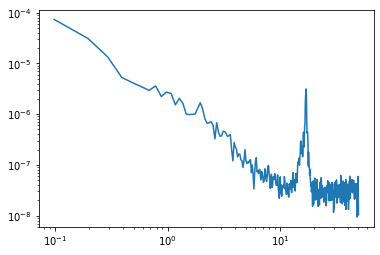

In [200]:
f, p = genpsd(ol, dt=0.01, nseg=8)
plt.loglog(f, p)

In [316]:
obs = Observer(f_sampling=100, time_id=20)
params, variances = obs.vibe_fit_freq(p)
kfv = obs.make_kfilter_vibe(params, variances * 1e9) # reset variances somehow
kft = obs.make_kfilter_ar(5, ol)
# kf = kfv + kft

Solved discrete ARE.
Solved discrete ARE.


In [317]:
def truncate_impulse(impulse, N=3):
    return impulse[:N] / np.sum(impulse[:N])

In [318]:
rms(ol[1000:])

0.004858569904830004

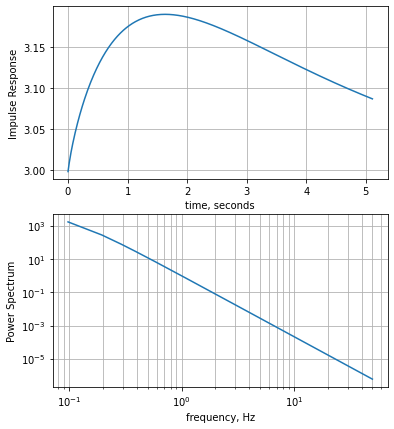

In [319]:
x_start = design_filt(dt=0.01)

0.002672276341998801

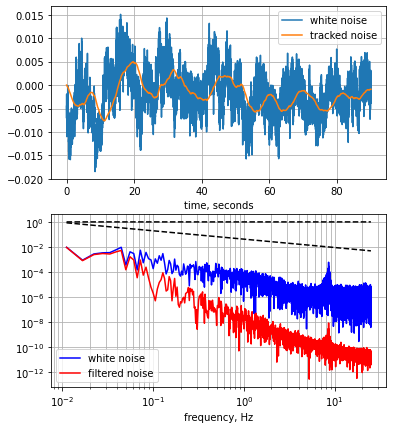

In [320]:
rms(filt(x_start, dt=0.01, u=ol[1001:]))

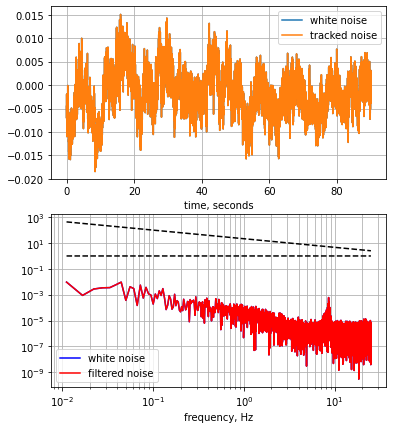

In [321]:
res = filt(truncate_impulse(x_start, N=1), dt=0.01, u=ol[1001:])

In [324]:
_, x_designed = design_from_ol(ol[:2000], dt=0.01, nseg=4)

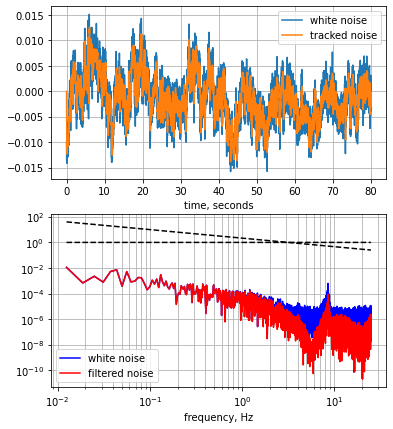

In [325]:
res = filt(truncate_impulse(x_designed, N=10), dt=0.01, u=ol[2001:])

In [337]:
states_v = kfv.run(res + np.random.normal(0, 0.01, (res.size,)), np.zeros(kfv.s,))

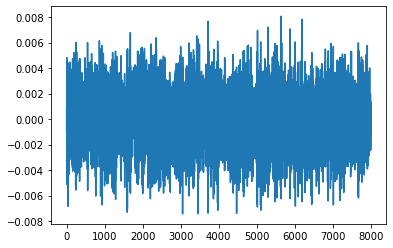

In [338]:
plt.plot(states_v @ kfv.C.T)

In [339]:
res2 = res - (states_v @ kfv.C.T).flatten()

In [340]:
rms(res2)

0.0044897978930773744